In [14]:
import os
import numpy as np
import copy
import anndata as ad
import pickle

toarray = lambda x: np.array(x,dtype=np.int16)
toembedding = lambda x: np.squeeze(x)
ann2embd = lambda ann,index: toembedding(toarray(ann.X[:,index].todense()))
ann2feaMat = lambda ann: toembedding(toarray(ann.X.todense()))
def get_paths(root):
    filenames = []
    for (dirpath, dirnames, filename) in os.walk(root):
        for file in filename:
            filenames.append(os.path.join(dirpath,file))
    return sorted(filenames)

def intersect(lst1, lst2): 
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3
def sort_xy_fea(pos,fea_mat):
    fea_mat = np.array([item for item in fea_mat])
    ind_x = pos[:,0].argsort()
    pos = pos[ind_x]
    fea_mat = fea_mat[ind_x]
    ind_y = pos[:,1].argsort()
    pos = pos[ind_y]
    fea_mat = fea_mat[ind_y]
    return pos,fea_mat

def split_by_y(xy_,gene_,round_i=0):
    xy = copy.deepcopy(xy_)
    gene = copy.deepcopy(gene_)
    result = []
    gene_result = []
    temp = []
    gene_temp = []
    pre_y = -1
    for item in xy:
        item_gene = gene.pop(0)
        if item[1].round(round_i) == pre_y or pre_y == -1:
            temp.append(item)
            gene_temp.append(item_gene)
        else:
            result.append(np.array(temp))
            gene_result.append(np.array(gene_temp))
            temp = [item]
            gene_temp = [item_gene]

        pre_y = item[1].round(round_i)
    result.append(np.array(temp))
    gene_result.append(np.array(gene_temp))
    return result,gene_result

def split_by_threhold(xy_,gene_,threhold=0.5):
    xy = copy.deepcopy(xy_)
    gene = copy.deepcopy(gene_)
    result = []
    gene_result = []
    temp = []
    gene_temp = []
    pre_y = -1
    for item in xy:
        item_gene = gene.pop(0)
        if np.abs(item[1] - pre_y) <threhold or pre_y == -1:
            temp.append(item)
            gene_temp.append(item_gene)
        else:
            result.append(np.array(temp))
            gene_result.append(np.array(gene_temp))
            temp = [item]
            gene_temp = [item_gene]

        pre_y = item[1]
    result.append(np.array(temp))
    gene_result.append(np.array(gene_temp))
        
    return result,gene_result


def rotate_coordinates(coordinates, angle):
    radians = np.deg2rad(angle)
    cos = np.cos(radians)
    sin = np.sin(radians)
    rotation_matrix = np.array([[cos, -sin], [sin, cos]])
    rotated_coordinates = np.dot(coordinates, rotation_matrix)    
    return rotated_coordinates

def get_pos_frames(slic,threhold=0.3):
    xy,gene = sort_xy_fea(slic.obsm['spatial'],ann2feaMat(slic))
    gene_li = [item for item in gene]
    #sorted_pos_fea = [split_by_y(rotate_coordinates(xy,angle/10),gene_li) for angle in range(-30,30)]
    
    sorted_pos_fea = [split_by_threhold(rotate_coordinates(xy,angle/10),gene_li,threhold) for angle in range(-30,30)]
    #sorted_pos_fea = [xy,gene_li,threhold]
    distribution = [item[0] for item in sorted_pos_fea]
    pos,frames = sorted_pos_fea[np.argmin([len(item) for item in distribution])]
    return {'Position':pos,'Gene_features':frames}

def get_inter_pos_frames(slice1_path,slice2_path,threhold=0.1):
    slice1 = ad.read_h5ad(slice1_path)
    slice2 = ad.read_h5ad(slice2_path)
    interIndex = intersect(slice1.var.index,slice2.var.index)
    slice1 = slice1[:,interIndex]
    slice2 = slice2[:,interIndex]
    return [get_pos_frames(slice1,threhold),get_pos_frames(slice2,threhold)]

def load_variable(path):
    df=open(path,'rb')
    data=pickle.load(df)
    df.close()
    return data


In [15]:
file_name = get_paths('Data/')[:2]
file_name2 = get_paths('Data/')[3:5]

In [16]:
slice1,slice2 = get_inter_pos_frames(file_name[0],file_name[1])
slice3,slice4 = get_inter_pos_frames(file_name2[0],file_name2[1],threhold=0.1)

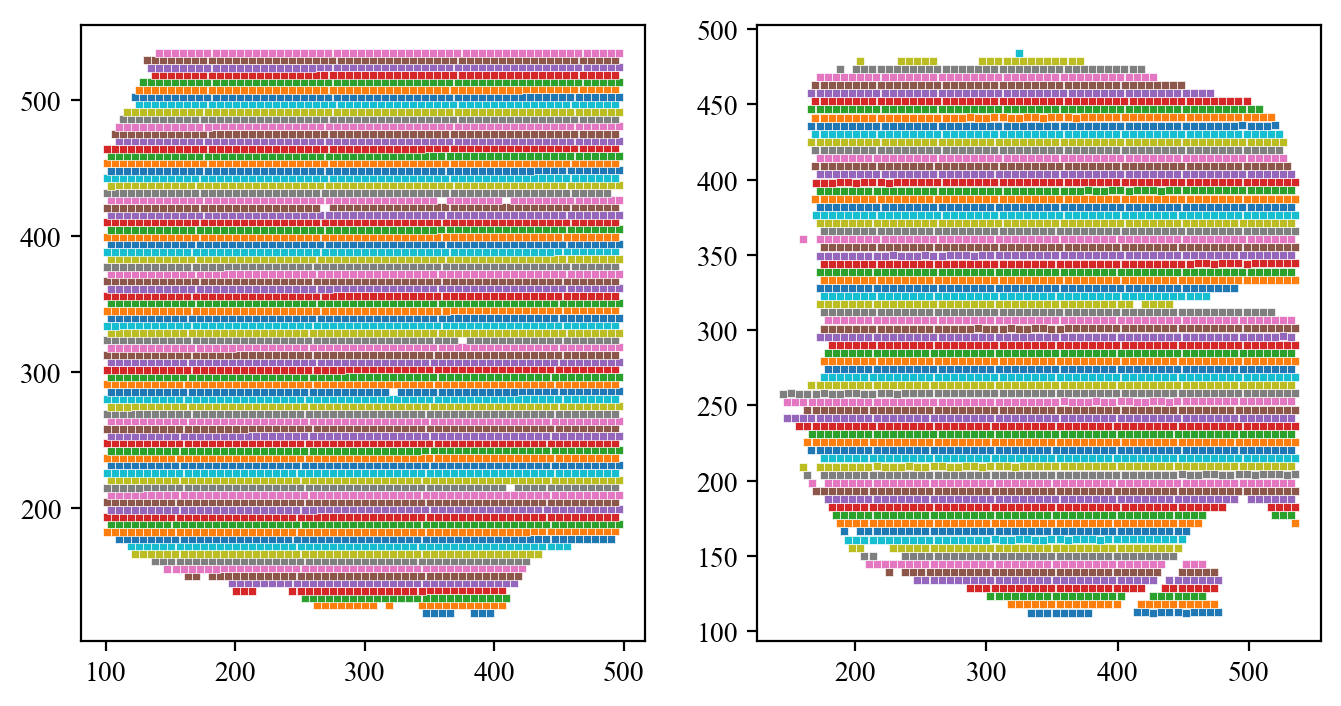

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
slice1.keys()
fig,ax = plt.subplots(1,2,dpi=200,figsize=(8,4))
for line in slice3['Position']:
    sns.scatterplot(x=line[:,0],y=line[:,1],s=9,ax=ax[0],marker='s')
for line in slice4['Position']:
    sns.scatterplot(x=line[:,0],y=line[:,1],s=9,ax=ax[1],marker='s')

plt.savefig('Rotation')